In [1]:
import sys
sys.executable

'/usr/bin/python3.6'

In [2]:
ls ../dockerdrive/

 02-acoustic-model.py*
 DASHclean/
 DASHnoisy/
'Data Loader.ipynb'
'Data Loader - Phoneme Level.ipynb'
'Data Loader - PLC feature.ipynb'
'Data Loader - With Dictionary.ipynb'
 dataset/
 datasets/
 dset.txt
'EDA on filters on data.ipynb'
 exp1_czt.h5
 exp1_stft.h5
'Experiment 1 - CZT - stabilized-Copy2.ipynb'
'Experiment 1 - CZT - stabilized.ipynb'
'Experiment 1 - CZT - stabilized with coeffs.ipynb'
'Experiment 1 - MFCC.ipynb'
'Experiment 1 - PLC - nan.ipynb'
'Experiment 1 - STFT.ipynb'
 Healthcheck.ipynb
'Knet installer and tester.ipynb'
 Krzysztok.ipynb
 lib/
 lstm.masking.harder.h5
 LSTM_Masking.ipynb
 models/
 NoisyTest2.tgz
'Simple Basic Acoustic Model for Larger Corpus - comparison.ipynb'
'Simple Basic Acoustic Model for Larger Corpus-Copy1.ipynb'
'Simple Basic Acoustic Model for Larger Corpus-Copy2.ipynb'
'Simple Basic Acoustic Model for Larger Corpus - CZT-Copy1.ipynb'
'Simple Basic Acoustic Model for Larger Corpus - CZT-Copy2.ipynb'
'Simple Basic Acoustic Model for Larger Corpu

In [1]:
import librosa
import numpy as np
import os
import scipy.io.wavfile as sio

cleans = []
noisy = []

more_cleans = [x for x in os.listdir("data-lite") if x.endswith("-clean.wav")][:350]
more_noisy = [x for x in os.listdir("data-lite") if not x.endswith("-clean.wav")][:350]
more_cleans = [sio.read("data-lite/" + x)[1].astype(np.float32) / 2**15 for x in more_cleans]
more_noisy = [sio.read("data-lite/" + x)[1].astype(np.float32) / 2**15 for x in more_noisy]
more_cleans = [np.abs(librosa.stft(x, n_fft=512, hop_length=128).T) for record in more_cleans for x in record.T]
more_noisy = [np.abs(librosa.stft(x, n_fft=512, hop_length=128).T) for record in more_noisy for x in record.T]
cleans = cleans + more_cleans
noisy = noisy + more_noisy
del more_cleans
del more_noisy

In [2]:
maxlen = max([x.shape[0] for x in cleans])
cleans = np.stack([np.pad(x, ((maxlen - x.shape[0], 0), (0, 0)), mode='constant', constant_values=0) for x in cleans])
noisy = np.stack([np.pad(x, ((maxlen - x.shape[0], 0), (0, 0)), mode='constant', constant_values=0) for x in noisy])

In [3]:
masks = np.clip(cleans / (noisy + 2e-12), 0, 1)


In [ ]:
"""
# Autoencoder
import keras
from keras.layers import Dense, LSTM, Conv2D, LeakyReLU, BatchNormalization, Flatten, TimeDistributed, Lambda
from keras.regularizers import L1L2

import keras.backend as K

model = keras.models.Sequential() 
model.add(Lambda(lambda x: -1 * K.log(x ** 2 + 2e-12)))
model.add(LSTM(512, input_shape=(None, 257), return_sequences=True, kernel_regularizer=L1L2(l1=1e-6), recurrent_regularizer=L1L2(l1=1e-6))) 
model.add(Dense(512)) 
model.add(LeakyReLU(0.01)) 
model.add(LSTM(512, return_sequences=True, kernel_regularizer=L1L2(l1=1e-6), recurrent_regularizer=L1L2(l1=1e-6))) 
model.add(Dense(512)) 
model.add(LeakyReLU(0.01)) 
model.add(LSTM(512, return_sequences=True, kernel_regularizer=L1L2(l1=1e-6), recurrent_regularizer=L1L2(l1=1e-6)))  
model.add(Dense(512)) 
model.add(LeakyReLU(0.01)) 
model.add(Dense(257, activation='relu')) 
model.add(Lambda(lambda x: K.sqrt(K.exp(-1 * x))))
model.compile(keras.optimizers.Adam(2e-3, clipnorm=1.), 'mse') 
model.summary()    

"""




In [4]:
import keras
import keras.backend as K
from keras.callbacks import Callback
from keras.layers import Input, Lambda, LeakyReLU, Conv2D, TimeDistributed, \
    Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import L1L2
import librosa
import numpy as np
import random

from utils import list_sounds, open_sound


def mk_model():
    input_lower = Input((None, 257), name="input_lf")
    layer = Lambda(K.expand_dims)(input_lower)
    layer = LeakyReLU(0.01)(Conv2D(32, kernel_size=(9, 1), activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(32, kernel_size=(1, 5), activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(32, kernel_size=(9, 1), activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(32, kernel_size=(1, 5), activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(2048, kernel_regularizer=L1L2(l1=1e-6, l2=1e-6))(layer))
    layer = LeakyReLU(0.01, name='hidden')(Dense(1024, kernel_regularizer=L1L2(l1=1e-6, l2=1e-6))(layer))
    layer = LeakyReLU(0.01)(Dense(512, kernel_regularizer=L1L2(l1=1e-6, l2=1e-6))(layer))
    layer = Dense(257)(layer)
    mdl = Model(input_lower, layer)
    return mdl


class StopOnConvergence(Callback):
    def __init__(self, max_repetitions=10):
        super().__init__()
        self.max_repetitions = max_repetitions

    def on_train_begin(self, logs=None):
        self.repetitions = 0
        self.last_loss = np.inf

    def on_epoch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('val_loss')
        if loss is not None:
            if loss > self.last_loss:
                self.repetitions += 1
            else:
                self.last_loss = loss
                self.repetitions = 0
            if self.repetitions > self.max_repetitions:
                self.model.stop_training = True

model = mk_model()
model.compile(keras.optimizers.Adam(1e-3, clipnorm=1.), 'mse') 
model.summary()    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lf (InputLayer)        (None, None, 257)         0         
_________________________________________________________________
lambda_4 (Lambda)            (None, None, 257, 1)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, None, 257, 32)     320       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, None, 257, 32)     0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, None, 253, 32)     5152      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, None, 253, 32)     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, None, 253, 32)     9248      
__________

In [ ]:
# TODO: train on proper noisy ones
model.fit(noisy[320:], masks[320:], epochs=100, batch_size=32, validation_data=[noisy[:320], masks[:320]])

Train on 4800 samples, validate on 320 samples
Epoch 1/100
3872/4800 [=======================>......] - ETA: 1:35 - loss: 0.1674

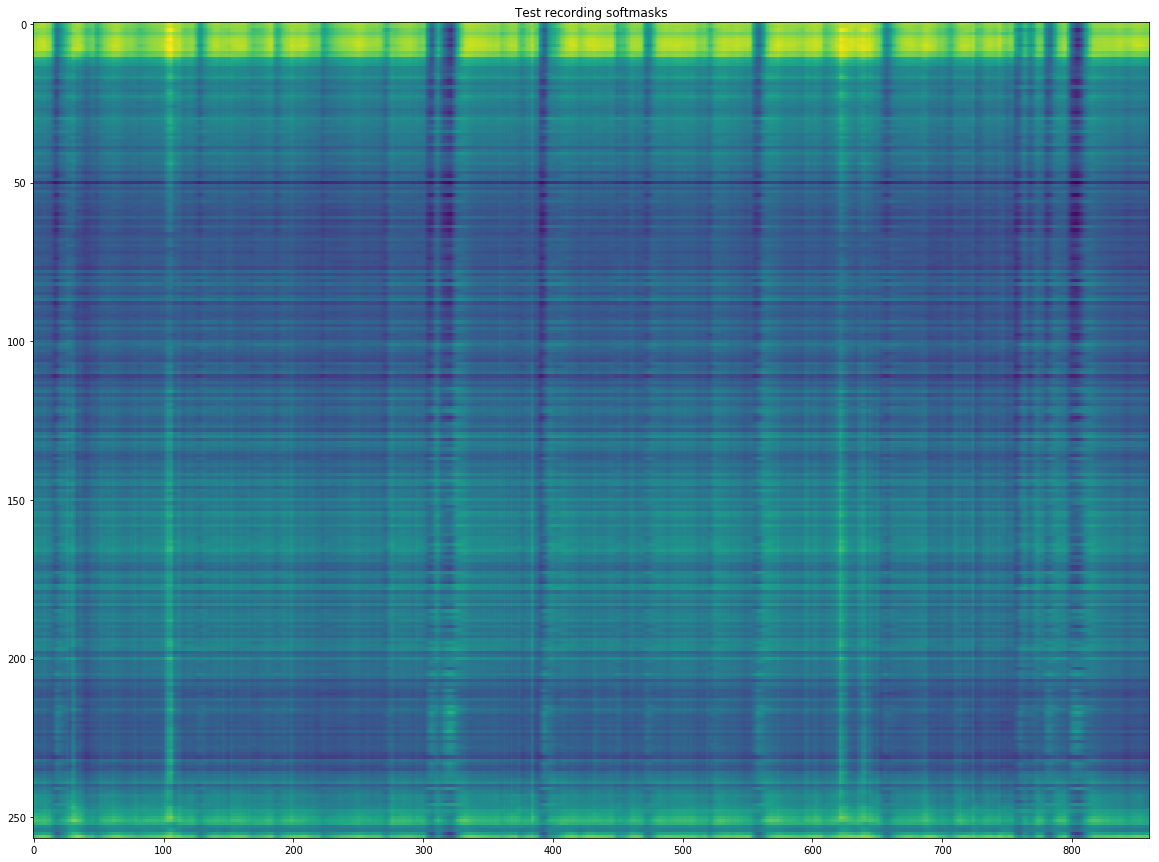

In [24]:
import matplotlib.pyplot as plt
a = model.predict(noisy[5081:5082])[0]
plt.figure(figsize=(20,15))
plt.imshow(np.flip(a.T[:, 230:], 0), aspect='auto')
plt.title("Test recording softmasks")
plt.show()

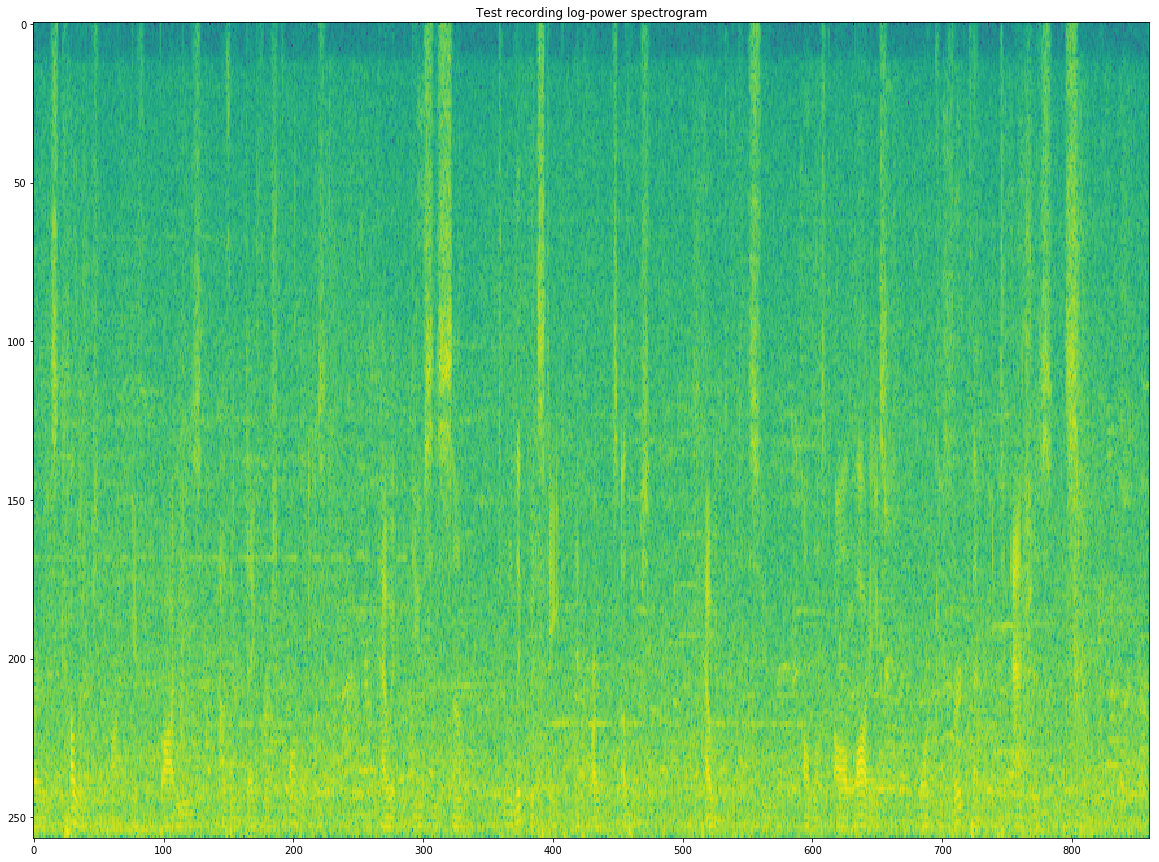

In [25]:
plt.figure(figsize=(20,15))
plt.imshow(np.flip(np.log(noisy[5081:5082][0].T[:, 230:]**2 + 2e-12), 0), aspect='auto')
plt.title("Test recording log-power spectrogram")
plt.show()

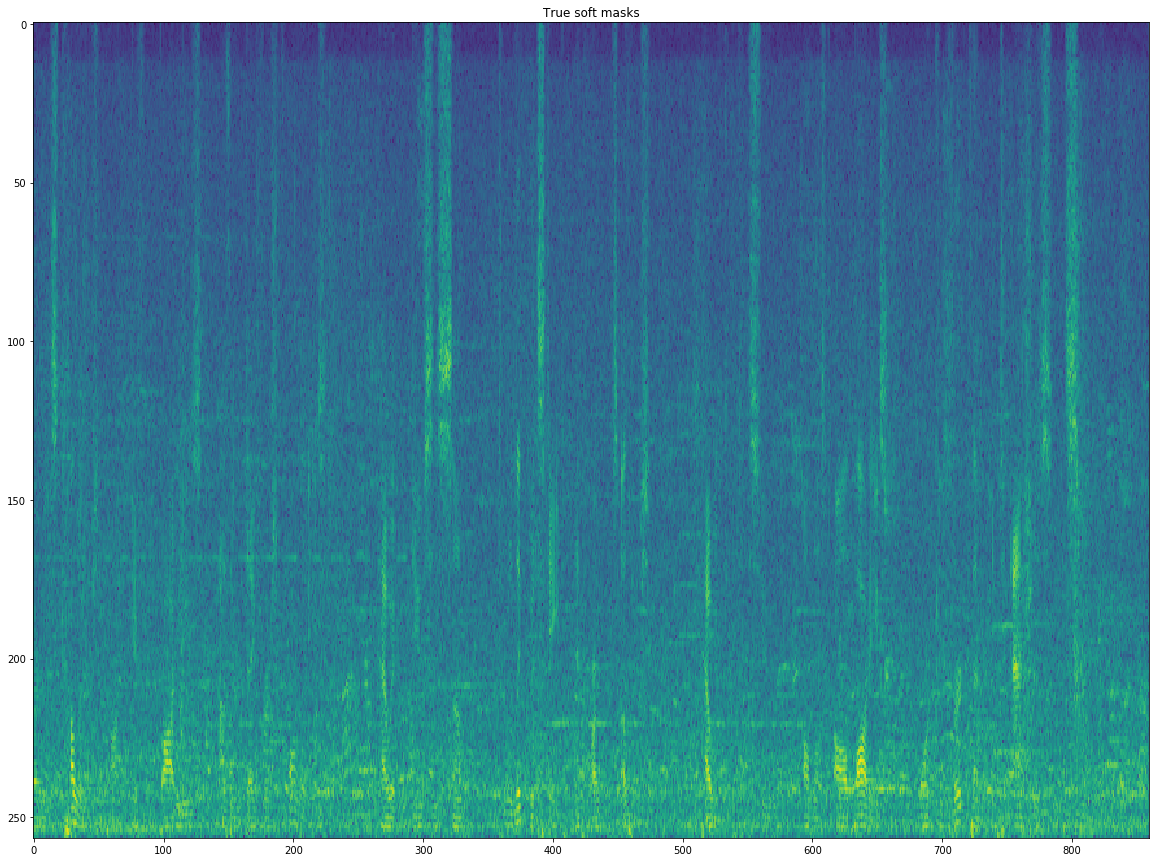

In [29]:
plt.figure(figsize=(20,15))
plt.imshow(np.flip(noisy[5081:5082][0].T[:, 230:], 0) ** 0.2, aspect='auto')
plt.title("True soft masks")
plt.show()

In [108]:
r = os.listdir("DASHnoisy")[520 // 6 + int(bool(520 % 6)) - 1]
d = sio.read("DASHnoisy/" + r)[1]
spec = librosa.stft(d.astype(np.float32).T[4] / 2**15, n_fft=512, hop_length=128).T
spec2 = a[-1934:]* spec
### mask = abs(clean) / abs(noise)
### abs(clean) = mask * abs(noise)
sound = librosa.istft(spec2.T, hop_length=128)

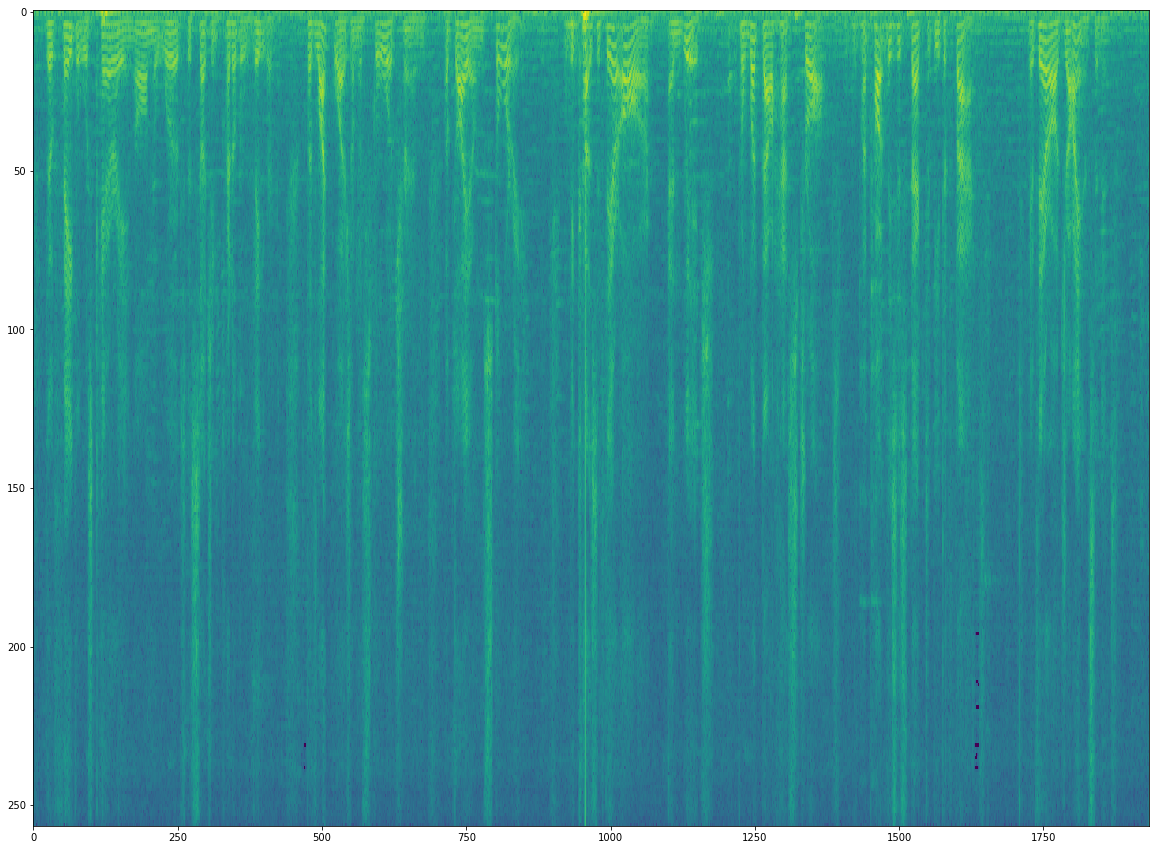

In [109]:
plt.figure(figsize=(20,15))
plt.imshow(np.abs(spec2.T)**0.1, aspect='auto')

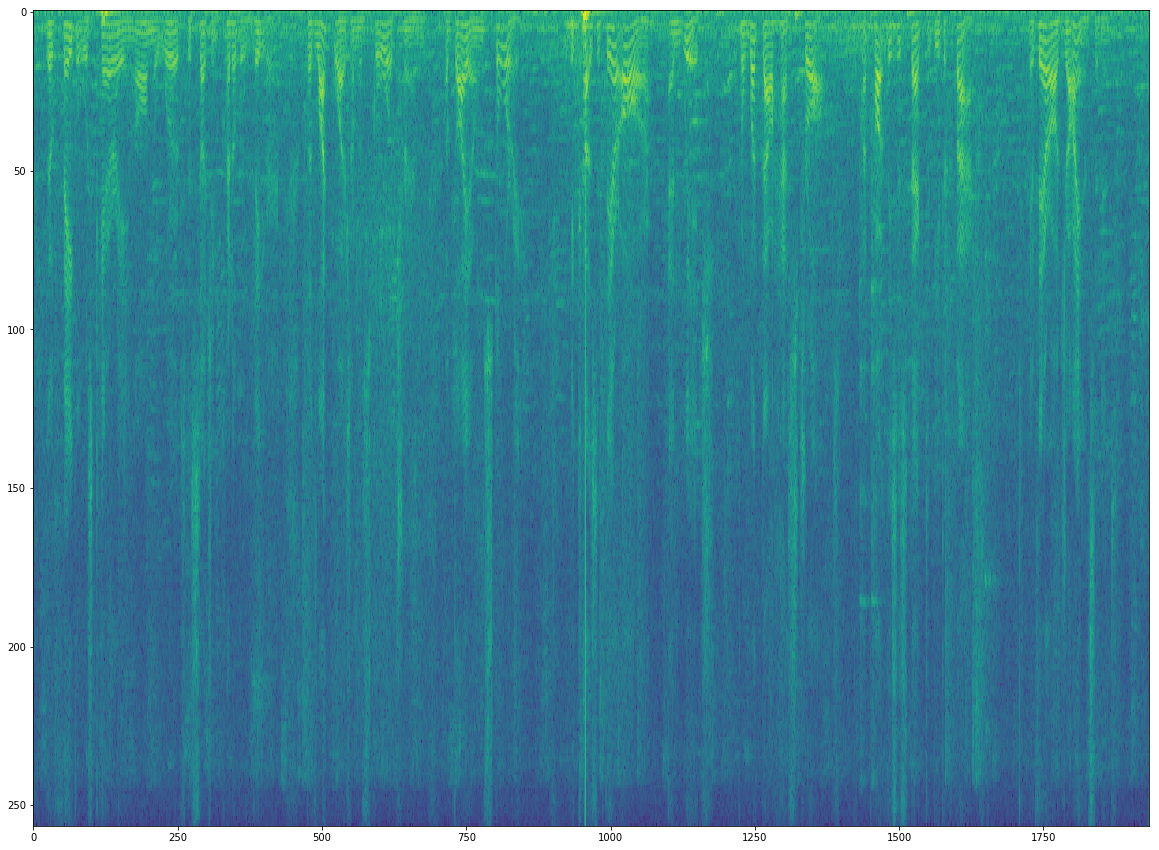

In [110]:
plt.figure(figsize=(20,15))
plt.imshow(np.abs(spec.T)**0.1, aspect='auto')

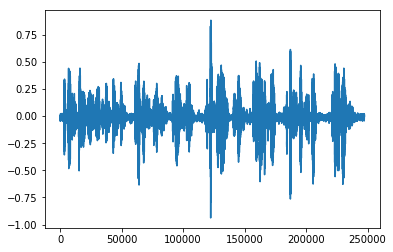

In [111]:
plt.plot(sound)
from IPython.display import display, Audio
display(Audio(sound, rate=16000))

In [113]:
display(Audio(d.T[4], rate=16000))

In [21]:
model.save("3layer-mask.h5") # model on GoogleDrive

In [32]:
a = sio.read("../8ch/277.wav")[1][:, 0].astype(np.float32)
a = librosa.stft(a, n_fft=512).T

mod = np.abs(a)
phs = np.angle(a)

A = model.predict(a.reshape(1, -1, 257))[0]
mod2 = (a * A) * np.exp(1j * phs)
sound = librosa.istft(mod2.T)
from IPython.display import display, Audio
display(Audio(sound, rate=16000))
sio.write("/home/zantyr/filtered-277.wav", 16000, sound)

In [30]:
a.shape

(257, 2016)

In [33]:
a = sio.read("../8ch/290.wav")[1][:, 0].astype(np.float32)
a = librosa.stft(a, n_fft=512).T

mod = np.abs(a)
phs = np.angle(a)

A = model.predict(a.reshape(1, -1, 257))[0]
mod2 = (a * A) * np.exp(1j * phs)
sound = librosa.istft(mod2.T)
from IPython.display import display, Audio
display(Audio(sound, rate=16000))
sio.write("/home/zantyr/filtered-290.wav", 16000, sound)